In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from collections import Counter
from plotly import express as ex

%matplotlib inline

In [2]:
PATH = "."

In [3]:
train = pd.read_csv(f"{PATH}/data.csv")

In [4]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245


In [5]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

In [6]:
train['h'] = train.ymax - train.ymin
train['w'] = train.xmax - train.xmin

train['y'] = train.ymin + (train.h / 2)
train['x'] = train.xmin + (train.w / 2)

In [7]:
train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,h,w,y,x
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.795312,0.306250,0.970313,0.529167,0.222917,0.175000,0.417708,0.882812
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.693750,0.304167,0.803125,0.537500,0.233333,0.109375,0.420833,0.748437


In [8]:
192 / 480

0.4

In [9]:
192 / 640

0.3

In [10]:
class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}

In [11]:
train['class'].unique()

array(['RBC', 'WBC', 'Platelets'], dtype=object)

In [322]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    group = grouped.get_group(i)[['class','xmin','ymin','xmax','ymax','x','y','h','w']]
#     group = group[group['class']]#.query('h > 0.4 and w > 0.3')
    group = group.T.to_dict().values()
    boxes = [JSON(i) for i in group]
    if len(boxes):
        data.append(JSON({
            'filename':i,
            'boxes':boxes
        }))

In [323]:
len(data)

364

In [324]:
64 * 6

384

In [325]:
IMG_SIZE = 384

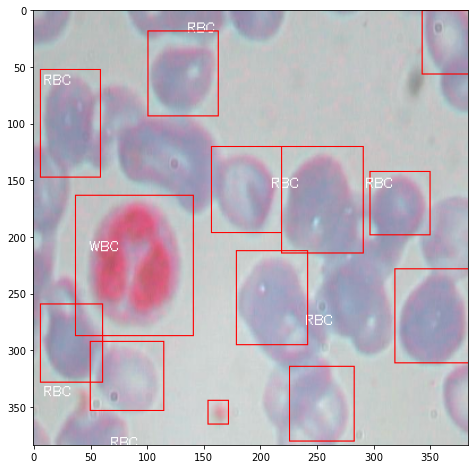

In [327]:
image = data[np.random.randint(len(data))]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box.xmin*IMG_SIZE),int(box.ymin*IMG_SIZE)),
            (int(box.xmax*IMG_SIZE),int(box.ymax*IMG_SIZE)),
            (255,0,0),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [328]:
images = np.array([cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)) for i in data])

In [329]:
images = images.astype(np.float32) / 255

In [331]:
hw = ((train[['h','w']].copy()*IMG_SIZE).astype(np.uint16) / 64)*64

In [332]:
ex.scatter(data_frame=hw,x='w',y='h')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


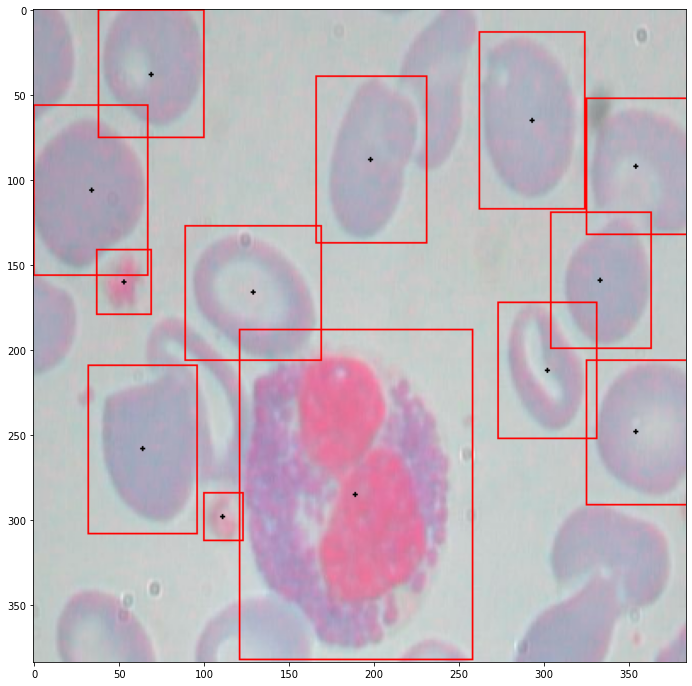

In [333]:
i = np.random.randint(len(images))

img = images[i].copy()
dat = data[i]

for d in dat.boxes:
    img = cv2.rectangle(
                    img,
                    (int(d.xmin*IMG_SIZE),int(d.ymin*IMG_SIZE)),
                    (int(d.xmax*IMG_SIZE),int(d.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    img = cv2.circle(
                    img,
                    (int(d.x*IMG_SIZE),int(d.y*IMG_SIZE)),
                    1,
                    (0,0,0),
                    -1
                )

plt.figure(figsize=(12,12
                   ))
plt.imshow(img)

In [466]:
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [623]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen):
        
        self.k = k
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = BoxGrid(**box_gen)
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob = np.zeros((self.grid_size,self.grid_size,self.k,1))

        data = data[np.logical_and(np.all(data[:,2:] <= self.box_gen.high,axis=1), np.any(data[:,2:] > self.box_gen.low,axis=1))]
        
        _counter = Counter()

        for y,x,h,w in data:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 

            if Ox == self.grid_size or Oy == self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            
            h,w = self.box_gen.encode(h,w)
                        
            Oi = _counter[f"{Oy}x{Ox}"]
            
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = [1]
            
            _counter[f"{Oy}x{Ox}"] += 1

        prob,box =  prob.reshape(-1,self.k,1),box.reshape(-1,self.k,4)
        return prob.reshape(-1,1),box.reshape(-1,4)
    
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        
        if ret:
            return self.grid.copy(),self.reference.copy()
    

In [624]:
# dat = data[0]

# boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in dat.boxes])*IMG_SIZE).astype(np.float32)
# boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

In [625]:
class AnchorLayer(object):
    """
    Encode Various Sizes Of FPNS
    """
    
    def __init__(self,k,img_size,config,):
        self.k = k
        self.img_size = img_size
        self.config = config
        
        for cfg in config:
            self.__dict__[f"ANCHOR_{cfg['name']}"] = AnchorGrid(**cfg['anchor_grid'])
            self.__dict__[f"ANCHOR_{cfg['name']}"].generate()
        
        self.ANCHORS = [i for (i,j) in self.__dict__.items() if "ANCHOR_" in i]
        
    def __repr__(self,):
        return self.config.__repr__()
    
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in data.boxes])*self.img_size).astype(np.float32)
        boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

        prob,box = [],[]
        
        for anchor in self.ANCHORS:
            p,b = self.__dict__[anchor](boxt)
            prob.append(p)
            box.append(b)
            
        prob = np.concatenate(prob,axis=0)
        box = np.concatenate(box,axis=0)
        
        
            
        return prob,box

In [642]:
k = 3

anchor_config = {
    "k":k,
    "img_size":IMG_SIZE,
    "config":[
        {
            "anchor_grid":{
                "resize_factor":32,
                "k":k,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":8,
                    "high":64
                }
            },
            "name":"FPN0"
        },
        {
            "anchor_grid":{
                "resize_factor":64,
                "k":k,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":64,
                    "high":128
                }
            },
            "name":"FPN1"
        },
        {
            "anchor_grid":{
                "resize_factor":128,
                "k":k,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":128,
                    "high":256
                }
            },
            "name":"FPN2"
        }
    ]
}

In [643]:
anchors = AnchorLayer(**anchor_config)

In [644]:
prob,box = anchors(data[0])

In [645]:
prob.shape

(567, 1)

In [646]:
box.shape

(567, 4)

In [647]:
# y_prob = []
# y_box = []

# for d in data:
#     p,b = anc(d)
    
#     y_box.append(b)
#     y_prob.append(p)
    
# y_prob = np.array(y_prob)
# y_box = np.array(y_box)

In [648]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [649]:
_input = Input(shape=(IMG_SIZE,IMG_SIZE,3))


def block(name:str,filters:int,ksize:int,_input:Layer,pool=False):
    block_0 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv0")(_input)
    block_1 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv1")(block_0)

    block_2 = BatchNormalization(name=f"block_{name}_norm_0")(block_1)
    block_3 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv2")(block_2)
    
    block_4 = Conv2D(filters,1,activation="relu",padding="same",name=f"block_{name}_conv3")(block_3)
    block_5 = BatchNormalization(name=f"block_{name}_norm_1")(block_4)

    block_out = concatenate([_input,block_5],name=f"block_{name}_conc")
    
    if pool:
        block_out = MaxPool2D(name=f"block_{name}_pool")(block_out)
    
    return block_out


def out(_in,k,name):
    prob = Conv2D(k,1,padding="same",name=f"prob_conv_{name}")(_in)
    prob = BatchNormalization(name=f"prob_norm_{name}")(prob)
    prob = Activation("sigmoid",name=f"prob_out_{name}")(prob)
    prob = Reshape((-1,1),name=f"{name}_prob")(prob)

    box = Conv2D(k*4,1,padding="same",name=f"box_conv_{name}")(_in)
    box = BatchNormalization(name=f"box_batch_{name}")(box)
    box = Activation("sigmoid",name=f"box_out_{name}")(box)
    box = Reshape((-1,4),name=f"{name}_box")(box)
    
    return prob,box

### input block
_in = Conv2D(32,7,activation="relu",padding="same",)(_input)
#### Output Shape = 192x192x32

### Fine Grained Features
a  = block(name="a",filters=32,ksize=3,_input=_in,pool=True) ### Output Shape = 96x96x64
b  = block(name="b",filters=64,ksize=3,_input=a,pool=True) ### Output Shape = 48x48x128
c  = block(name="c",filters=128,ksize=3,_input=b,pool=True) ### Output Shape = 24x24x256
d  = block(name="d",filters=256,ksize=3,_input=c,pool=True) ### Output Shape = 24x24x256

fpn0  = block(name="fpn0",filters=512,ksize=1,_input=d,pool=True) ### 12x12x512
(prob_0,box_0) = out(fpn0,3,"fpn0")

fpn1  = block(name="fpn1",filters=1024,ksize=1,_input=fpn0,pool=True) ### 6x6x1024
(prob_1,box_1) = out(fpn1,3,"fpn1")

fpn2  = block(name="fpn2",filters=2048,ksize=1,_input=fpn1,pool=True) ### 3x3x2048
(prob_2,box_2) = out(fpn2,3,"fpn2")

prob_out = concatenate([prob_0,prob_1,prob_2],1,name="prob")
box_out = concatenate([box_0,box_1,box_2],1,name="box")

net = keras.Model(_input,[prob_out,box_out])

In [650]:
# keras.utils.plot_model(net,show_shapes=True,show_layer_names=True,expand_nested=True,dpi=128)

In [651]:
net.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 384, 384, 32) 4736        input_22[0][0]                   
__________________________________________________________________________________________________
block_a_conv0 (Conv2D)          (None, 384, 384, 32) 9248        conv2d_21[0][0]                  
__________________________________________________________________________________________________
block_a_conv1 (Conv2D)          (None, 384, 384, 32) 9248        block_a_conv0[0][0]              
___________________________________________________________________________________________

In [652]:
%%time

i = np.random.randint(0,len(images))
a = net(images[i:i+1])

Wall time: 169 ms


In [653]:
p,b = a

In [655]:
p.shape,b.shape

(TensorShape([1, 567, 1]), TensorShape([1, 567, 4]))

In [656]:
prob.shape

(567, 1)

In [657]:
box.shape

(567, 4)

In [211]:
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

In [213]:
i = 0
_,y_pred  = net(images[i:i+1])
y_true  = y_box[i:i+1].copy().astype(np.float32)

In [214]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,grid_size,k):
        self.grid_size = grid_size
        self.k = k
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.two = tf.constant(2,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""
BoxLoss(
    grid_size={grid_size},
    k={k}
)
        """
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        b_pred = tf.reshape(y_pred,(-1,self.k*self.grid_size*self.grid_size,4))
        b_true = tf.reshape(y_true,(-1,self.k*self.grid_size*self.grid_size,4))
        
        y = tf.slice(b_true,**self.slice_y)
        x = tf.slice(b_true,**self.slice_x)

        mask = tf.logical_or(tf.greater(y,self.zero),tf.greater(x,self.zero))

        y = y[mask] 
        x = x[mask] 
        h = tf.slice(b_true,**self.slice_h)[mask] 
        w = tf.slice(b_true,**self.slice_w)[mask] 

        y_ = tf.slice(b_pred,**self.slice_y)[mask] 
        x_ = tf.slice(b_pred,**self.slice_x)[mask] 
        h_ = tf.slice(b_pred,**self.slice_h)[mask] 
        w_ = tf.slice(b_pred,**self.slice_w)[mask] 
        
        w2  = tf.divide(w,self.two)
        h2  = tf.divide(h,self.two)
        w2_  = tf.divide(w_,self.two)
        h2_  = tf.divide(h_,self.two)
        
        xmin = tf.subtract(x,w2)
        xmax = tf.add(x,w2)
        ymin = tf.subtract(y,h2)
        ymax = tf.add(y,h2)
        
        xmin_ = tf.subtract(x_,w2_)
        xmax_ = tf.add(x_,w2_)
        ymin_ = tf.subtract(y_,h2_)
        ymax_ = tf.add(y_,h2_)
        
        Cymin = tf.maximum(ymin,ymin_)
        Cymax = tf.minimum(ymax,ymax_)
        Cxmin = tf.maximum(xmin,xmin_)
        Cxmax = tf.minimum(xmax,xmax_)

        Ch = tf.subtract(Cymax , Cymin)
        Cw = tf.subtract(Cxmax , Cxmin)
        
        Aa = tf.multiply( h , w )
        Ba = tf.multiply( h_ , w_ )
        Ca = tf.multiply( Cw , Ch )
        
        IoU = tf.reduce_mean(tf.subtract(self.one,tf.divide(Ca,tf.subtract(tf.add(Aa,Ba),Ca))))
        Xl2 = self.l2_loss(x,x_)
        Yl2 = self.l2_loss(y,y_)
        
        return Xl2 + Yl2 + IoU

In [215]:
boxloss = BoxLoss(12,k)
boxloss


BoxLoss(
    grid_size=12,
    k=3
)
        

In [222]:
def schedule(epoch):
#     return .0001
    if epoch > 50:
        return .000001
    elif epoch > 30:
        return .00001
    elif epoch > 15:
        return .0001
    else:
        return .001

In [223]:
lrs = LearningRateScheduler(schedule=schedule,)
chk = ModelCheckpoint(filepath="./checkpoints/net1.1",save_weights_only=True,monitor='loss',)

In [224]:
opt = keras.optimizers.Adam()

In [225]:
net.compile(optimizer=opt,loss={"prob":binary_crossentropy,"box":boxloss})

In [226]:
# net.load_weights("./checkpoints/net1.1")

In [227]:
net.fit(images,(y_prob,y_box),batch_size=1,epochs=60,callbacks=[chk])

Train on 201 samples
Epoch 1/60
201/201 [==============================] - 42s 208ms/sample - loss: 0.6741 - prob_loss: 0.0215 - box_loss: 0.6525
Epoch 2/60
201/201 [==============================] - 41s 202ms/sample - loss: 0.6429 - prob_loss: 0.0193 - box_loss: 0.6236
Epoch 3/60
201/201 [==============================] - 40s 200ms/sample - loss: 0.5584 - prob_loss: 0.0165 - box_loss: 0.5419
Epoch 4/60
201/201 [==============================] - 40s 199ms/sample - loss: 0.5181 - prob_loss: 0.0152 - box_loss: 0.5029
Epoch 5/60
201/201 [==============================] - 42s 211ms/sample - loss: 0.5014 - prob_loss: 0.0136 - box_loss: 0.4878
Epoch 6/60
201/201 [==============================] - 43s 215ms/sample - loss: 0.4919 - prob_loss: 0.0123 - box_loss: 0.4795
Epoch 7/60
201/201 [==============================] - 41s 204ms/sample - loss: 0.4739 - prob_loss: 0.0115 - box_loss: 0.4624
Epoch 8/60
201/201 [==============================] - 41s 205ms/sample - loss: 0.4570 - prob_loss: 0.011

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29 24
27 22
29 28


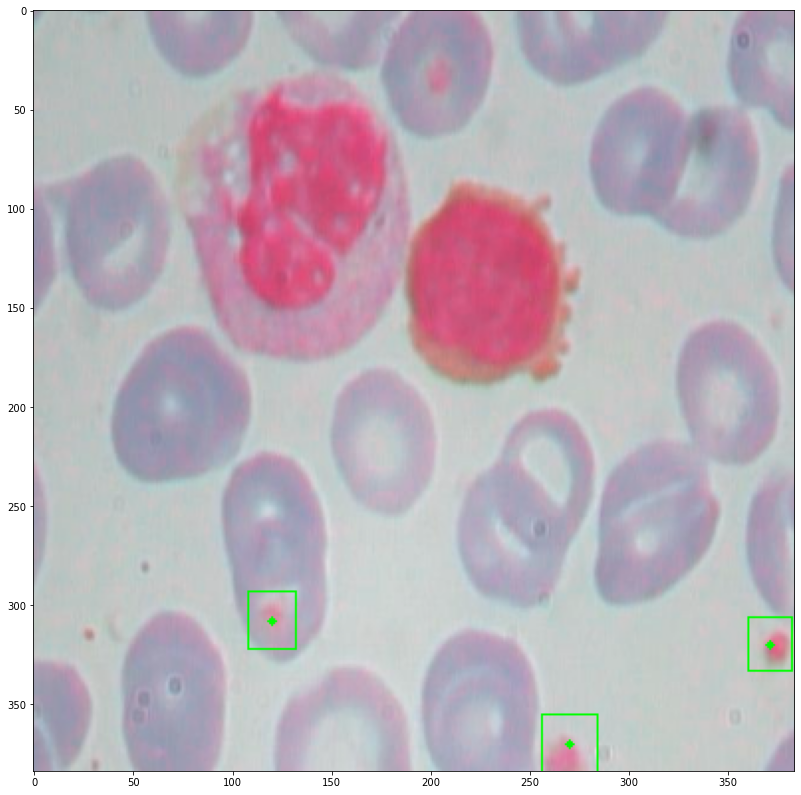

In [256]:
i = np.random.randint(len(images))

img = images[i].copy()
pa,ba = net.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
dat = data[i]

for (y,x),ps,bs in zip(grid.reshape(-1,2),pa.reshape(-1,k,1),ba.reshape(-1,k,4)):
    
    for (p,),(yy,xx,hh,ww) in zip(ps,bs):
        if p > .5:
            yy,xx = int(yy*32),int(xx*32)
            xx,yy = x-16+xx,y-16+yy
            img = cv2.circle(img,(xx,yy),2,(0,255,0),-1)
            
            hh = int(hh*64)
            ww = int(ww*64)
            
            print (hh,ww)
            
            xmin = int(xx - (ww/2))
            ymin = int(yy - (hh/2))
            
            xmax = int(xx + (ww/2))
            ymax = int(yy + (hh/2))
            
            img = cv2.rectangle(
                img,
                (xmin,ymin),
                (xmax,ymax),
                (0,255,0),
                1
            )
    
# for j,b in enumerate(dat.boxes):
#     img = cv2.rectangle(
#                     img,
#                     (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
#                     (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
#                     (255,0,0),
#                     1
#                 )
    
plt.figure(figsize=(14,14))
plt.imshow(img)

In [ ]:
# img = cv2.rectangle(
#     img,
#     (x-(anc_6x6.resize_factor//2),y-(anc_6x6.resize_factor//2)),
#     (x+(anc_6x6.resize_factor//2),y+(anc_6x6.resize_factor//2)),
#     (255,255,0),
#     1
# )